## Mood Detector With Tensorflow

In [1]:
# Import libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf  # Correct way to import TensorFlow
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential, save_model, Model
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam

The next code defines our image input size, batch size (how many images are processed at once), number of color channels (RGB), and how many times the model will train on the full dataset (epochs).

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [4]:
# Lloading the dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "train_ds",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE 
    
)

print("The total batches in the dataset is", len(dataset))

Found 894 files belonging to 5 classes.
The total batches in the dataset is 28


In [5]:
# checking the class names
class_names = dataset.class_names
class_names

['Sad', 'Surprised', 'angry', 'happy', 'normal']

(32, 256, 256, 3)


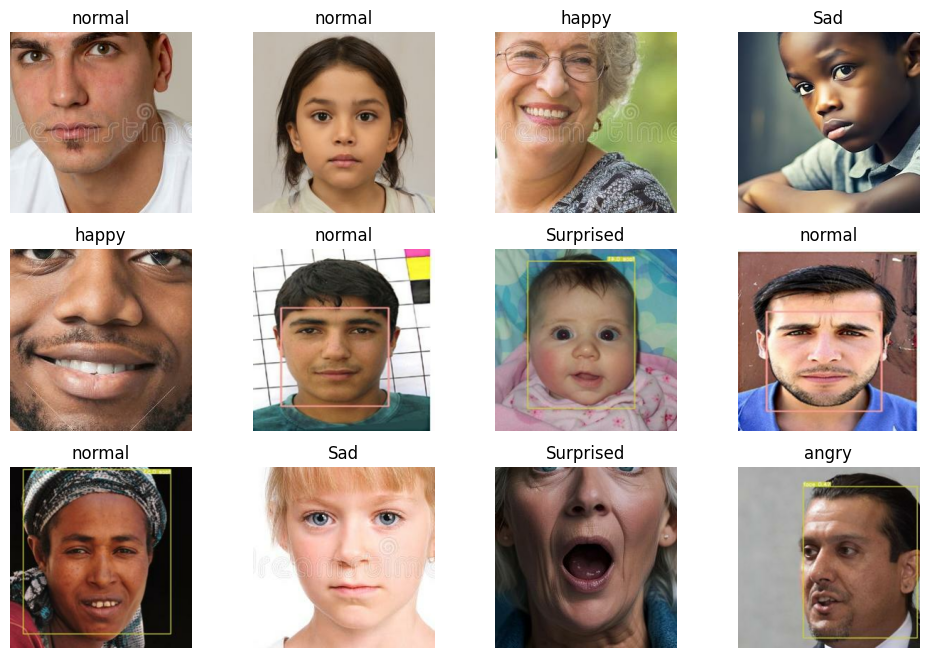

In [7]:
plt.figure(figsize = (12,8))
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    for i in range(min(12, image_batch.shape[0])):
        ax= plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i].numpy()])
        plt.axis("off")
        


In [8]:
# Splitting the dataset into train, test and validation
# 80% training
# 10% validation 
# # 10% test

def get_dataset_partitions(ds, train_split=0.8, val_split=0.2, shuffle = True, shuffle_size= 10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)  #seed is for predictability
    train_size = int(ds_size * train_split)
    val_size = int(ds_size * val_split)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    
    
    
    return train_ds, val_ds

In [9]:
train_ds, val_ds = get_dataset_partitions(dataset)
len(train_ds), len(val_ds)

(22, 5)

In [10]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)


In [11]:
# preprocessing/scaling the images

resize_and_rescale = Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE), # Accepts image input of fixed shape
    layers.Rescaling(1.0/255),
    ])

In [12]:
# Data augmentation generates new images by slightly modifying existing ones
# This helps to prevent overfitting by providing more diverse training data
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
    layers.RandomTranslation(0.2, 0.2)
])

In [13]:
input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 5
model = models.Sequential([
    layers.Input(shape=input_shape),                # Input layer
    resize_and_rescale,
    data_augmentation,                                        # Data augmentation layer
    layers.Conv2D(32, (3,3), activation='relu'),    # 32 filters will be detected. kernel size of 3x3
    layers.MaxPooling2D((2,2)),                     #  Takes a small region and keeps the maximum value
    Dropout(0.5),                                   #prevents overfitting by making the model less reliant on any one neuron
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    Dropout(0.5),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    Dropout(0.5),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    Dropout(0.5),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    Dropout(0.5),
    layers.Dense(n_classes, activation='softmax')   # output layer with softmax activation for multi-class classification
    ])

model.build(input_shape = (None, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

In [14]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       802,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 896,453 (3.42 MB)

 Trainable params: 896,453 (3.42 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# compile the model
model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [16]:
#  The variable history is used to store the training history returned by model.fit
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds,
    #callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.2139 - loss: 1.9049 - val_accuracy: 0.3500 - val_loss: 1.6060
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.3487 - loss: 1.5845 - val_accuracy: 0.3500 - val_loss: 1.5956
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.3206 - loss: 1.5601 - val_accuracy: 0.3500 - val_loss: 1.5900
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.3114 - loss: 1.5785 - val_accuracy: 0.3500 - val_loss: 1.5731
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.3272 - loss: 1.5713 - val_accuracy: 0.3500 - val_loss: 1.5719
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.3014 - loss: 1.5615 - val_accuracy: 0.3500 - val_loss: 1.5584
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.3372 - loss: 1.5265 - val_accuracy: 0.3500 - val_loss: 1.5548
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.3470 - loss: 1.5499 - val_accuracy: 0.3500 - val_loss:

In [17]:
scores = model.evaluate(val_ds)

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 301ms/step - accuracy: 0.4052 - loss: 1.4168


In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))  # Instead of EPOCHS, in case EarlyStopping kicked in early

Text(0.5, 1.0, 'Training and Validation Loss')

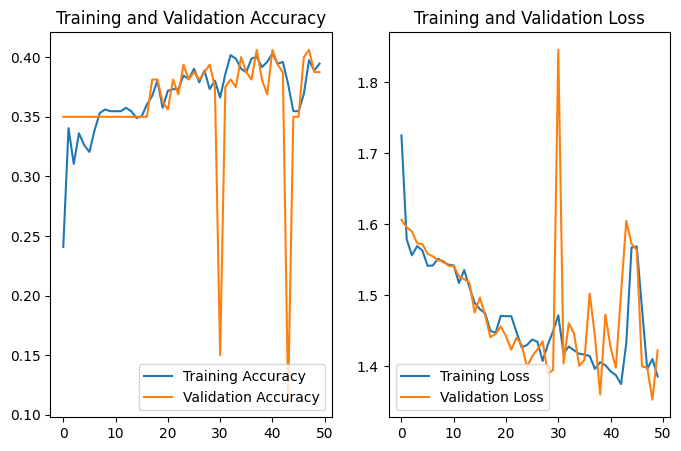

In [19]:
# graph showing the training and validation accuracy
plt.figure(figsize = (8,5))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

# Graph showing the training loss and validation loss
plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'lower left')
plt.title('Training and Validation Loss')


## Transfer Learning

In [20]:
input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 5

base_model = MobileNetV2(input_shape = input_shape, include_top = False, weights = 'imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation = 'relu')(x)
output = Dense(n_classes, activation = 'softmax')(x)

model = Model(inputs = base_model.input, outputs = output)

# Freeze base model
for layer in base_model.layers:
  layer.trainable  = False

model.compile(
    optimizer = Adam(1e-4),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)


C:\Users\NGARE\AppData\Local\Temp\ipykernel_15496\72601987.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape = input_shape, include_top = False, weights = 'imagenet')


In [21]:
# Load data

train_dir = 'train_ds'
val_dir = 'val_ds'

In [22]:
for filename in os.listdir(train_dir):
  print(filename)

angry
happy
normal
Sad
Surprised


In [23]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical'
)

Found 894 images belonging to 5 classes.
Found 300 images belonging to 5 classes.


In [24]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    steps_per_epoch=train_generator.samples // 32,
    validation_steps=val_generator.samples // 32
)


c:\Users\NGARE\DS_Python_Lux\Ds_projects\CH2 PROJECT\Mood-Detector-With-TensorFlow\fvenv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2535 - loss: 1.7055

c:\Users\NGARE\DS_Python_Lux\Ds_projects\CH2 PROJECT\Mood-Detector-With-TensorFlow\fvenv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


27/27 ━━━━━━━━━━━━━━━━━━━━ 66s 2s/step - accuracy: 0.2558 - loss: 1.7008 - val_accuracy: 0.3229 - val_loss: 1.5003
Epoch 2/20
 1/27 ━━━━━━━━━━━━━━━━━━━━ 30s 1s/step - accuracy: 0.4688 - loss: 1.4448

c:\Users\NGARE\DS_Python_Lux\Ds_projects\CH2 PROJECT\Mood-Detector-With-TensorFlow\fvenv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 434ms/step - accuracy: 0.4688 - loss: 1.4448 - val_accuracy: 0.3299 - val_loss: 1.4854
Epoch 3/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.4313 - loss: 1.3686 - val_accuracy: 0.3750 - val_loss: 1.4277
Epoch 4/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 421ms/step - accuracy: 0.5000 - loss: 1.2689 - val_accuracy: 0.3750 - val_loss: 1.4250
Epoch 5/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.5363 - loss: 1.1648 - val_accuracy: 0.4375 - val_loss: 1.3434
Epoch 6/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 426ms/step - accuracy: 0.7500 - loss: 0.8841 - val_accuracy: 0.4340 - val_loss: 1.3513
Epoch 7/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.5959 - loss: 1.0681 - val_accuracy: 0.4514 - val_loss: 1.3001
Epoch 8/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 374ms/step - accuracy: 0.5938 - loss: 1.0932 - val_accuracy: 0.4583 - val_loss: 1.3096
Epoch 9/20
27/27 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.5933 - loss: 1.0220 - val_accuracy: 0.5000 - val_loss

In [25]:
# Evaluate the model
loss, accuracy = model.evaluate(val_generator)
print(f"Validation Accuracy: {accuracy:.2f}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.5507 - loss: 1.2237
Validation Accuracy: 0.56


In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss= history.history['loss']
val_loss = history.history['val_loss']
epochs_range= range(len(acc))  # Instead of EPOCHS, in case EarlyStopping kicked in early

Text(0.5, 1.0, 'Training and Validation Loss')

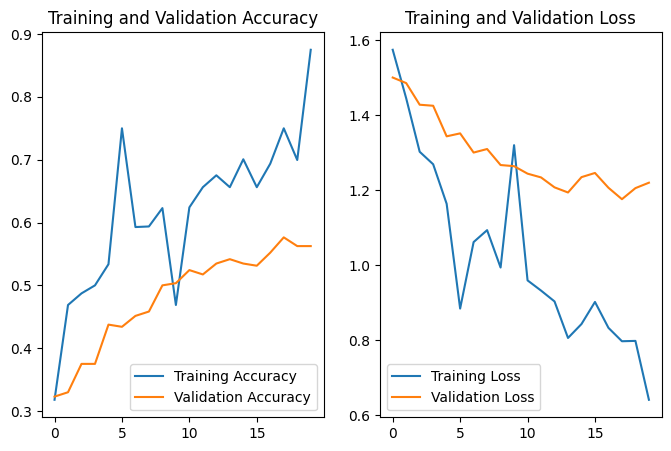

In [27]:
# graph showing the training and validation accuracy
plt.figure(figsize = (8,5))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

# Graph showing the training loss and validation loss
plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'lower left')
plt.title('Training and Validation Loss')

In [28]:
# (optional) Unfreeze and fine tune
# Unfreeze the last few layers of base model
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Compile again with a lower learning rate
model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Fine-tune
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)


Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 110s 3s/step - accuracy: 0.4037 - loss: 1.5600 - val_accuracy: 0.4900 - val_loss: 1.4500
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step - accuracy: 0.6040 - loss: 1.1087 - val_accuracy: 0.4367 - val_loss: 1.6899
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 145s 3s/step - accuracy: 0.6763 - loss: 0.8899 - val_accuracy: 0.4233 - val_loss: 1.7720
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 147s 3s/step - accuracy: 0.7190 - loss: 0.8050 - val_accuracy: 0.4167 - val_loss: 1.7777
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 134s 5s/step - accuracy: 0.7594 - loss: 0.7397 - val_accuracy: 0.4267 - val_loss: 1.7658
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 134s 4s/step - accuracy: 0.7669 - loss: 0.6936 - val_accuracy: 0.4400 - val_loss: 1.7228
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 112s 4s/step - accuracy: 0.7799 - loss: 0.7168 - val_accuracy: 0.4567 - val_loss: 1.6848
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 113s 4s/step - accuracy: 0.8030 - loss: 0.6091 - val_accuracy: 0.4700 - va

In [29]:
loss, accuracy = model.evaluate(val_generator)
print(f"Validation Accuracy: {accuracy:.2f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - accuracy: 0.4904 - loss: 1.5718
Validation Accuracy: 0.48


In [30]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss= history.history['loss']
val_loss = history.history['val_loss']
epochs_range= range(len(acc))  # Instead of EPOCHS, in case EarlyStopping kicked in early

Text(0.5, 1.0, 'Training and Validation Loss')

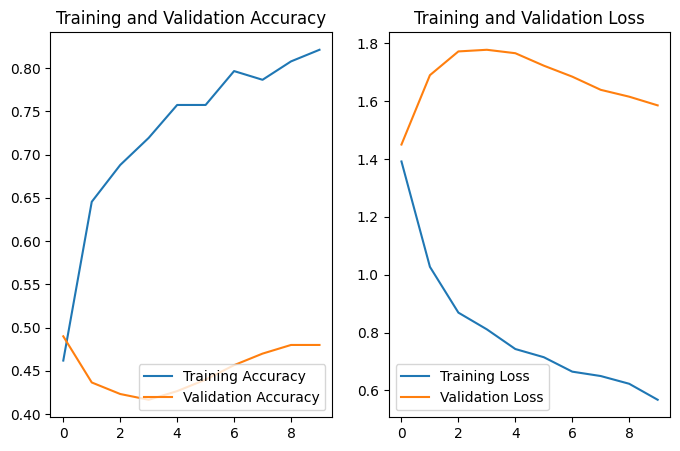

In [31]:
# graph showing the training and validation accuracy
plt.figure(figsize = (8,5))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label = 'Training Accuracy')
plt.plot(epochs_range, val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

# Graph showing the training loss and validation loss
plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'lower left')
plt.title('Training and Validation Loss')